In [14]:
# from sklearn.ensemble import VotingRegressor
# help(VotingRegressor)

Help on class VotingRegressor in module sklearn.ensemble._voting:

class VotingRegressor(sklearn.base.RegressorMixin, _BaseVoting)
 |  VotingRegressor(estimators, *, weights=None, n_jobs=None, verbose=False)
 |  
 |  Prediction voting regressor for unfitted estimators.
 |  
 |  A voting regressor is an ensemble meta-estimator that fits several base
 |  regressors, each on the whole dataset. Then it averages the individual
 |  predictions to form a final prediction.
 |  
 |  Read more in the :ref:`User Guide <voting_regressor>`.
 |  
 |  .. versionadded:: 0.21
 |  
 |  Parameters
 |  ----------
 |  estimators : list of (str, estimator) tuples
 |      Invoking the ``fit`` method on the ``VotingRegressor`` will fit clones
 |      of those original estimators that will be stored in the class attribute
 |      ``self.estimators_``. An estimator can be set to ``'drop'`` using
 |      ``set_params``.
 |  
 |      .. versionchanged:: 0.21
 |          ``'drop'`` is accepted. Using None was depr

In [5]:
class VotingRegressor():

    # 接收基學習器
    def __init__(self, base_learners):
        self.base_learners = {}
        for name, learner in base_learners:
            self.base_learners[name] = deepcopy(learner)


    # 訓練個別基學習器
    def fit(self, x_data, y_data):
        for name in self.base_learners:
            learner = self.base_learners[name]
            learner.fit(x_data, y_data)

    # 產生預測
    def predict(self, x_data):

        predictions = np.zeros((len(x_data), len(self.base_learners)))
        names = list(self.base_learners.keys())

        # 每一個基學習器都做預測
        for i in range(len(self.base_learners)):
            name = names[i]
            learner = self.base_learners[name]

            # 將基學習器的預測存在對應的欄
            preds = learner.predict(x_data)
            predictions[:,i] = preds

        # 計算每列的平均
        predictions = np.mean(predictions, axis=1)
        return predictions


In [6]:
def simulate(data, preds):
    # 常數與暫存變數
    buy_threshold = 0.5
    stake = 100

    true, pred, balances = [], [], []

    buy_price = 0
    buy_points, sell_points = [], []
    balance = 0

    start_index = len(data) - len(preds) - 1

    # 計算預測值
    for i in range(len(preds)):
        # 昨日收盤價
        last_close = data.Close[i+start_index-1]
        # 今日收盤價
        current_close = data.Close[i+start_index]

        # 儲存今日收盤價
        true.append(current_close)
        # 儲存今日預測收盤價
        # 使用昨日收盤價跟模型預測的變化百分比換算而得
        pred.append(last_close*(1+preds[i]/100))


        # 根據預測進行交易
        # 預測會漲價並且手上沒有比特幣
        if preds[i] > buy_threshold and buy_price == 0:
            buy_price = true[-1]
            buy_points.append(i)

        # 預測會下跌且手上持有比特幣
        elif preds[i] < -buy_threshold and not buy_price == 0:
            profit = (current_close - buy_price) * stake / buy_price
            balance += profit
            buy_price = 0
            sell_points.append(i)

        balances.append(balance)


    true = np.array(true)
    pred = np.array(pred)

    # 繪製圖表
    plt.figure(figsize = (8, 8))
    plt.scatter(buy_points, true[buy_points]+500, 
                marker='x', label = "buy")
    plt.scatter(sell_points, true[sell_points]-500, 
                marker='o', label = "sell", s = 5)
    plt.plot(true, label = 'True', c = 'red')
    plt.plot(pred, label = 'pred', linestyle = '--', 
             c = 'black')
    plt.title('Trades')
    plt.legend()
    plt.show()

    plt.figure(figsize = (8, 8))
    plt.plot(balances)
    plt.title('Profit')
    plt.show()
    print('MSE: %.2f'%metrics.mean_squared_error(true, pred))
    balance_df = pd.DataFrame(balances)

    pct_returns = balance_df.diff()/stake
    pct_returns = pct_returns[pct_returns != 0].dropna()


    print('Sharpe: %.2f'%(np.mean(pct_returns)/np.std(pct_returns)))

In [7]:
def create_x_data(lags=1):
    diff_data = np.zeros((diff_len, lags))

    for lag in range(1, lags+1):
        this_data = diffs[:-lag]
        diff_data[lag:, lag-1] = this_data

    return  diff_data

In [8]:
# 第 1 部分
# 載入函式庫
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# 載入資料集
np.random.seed(123456)
data = pd.read_csv('../Data/BTC-USD.csv')

# 特徵工程
# 刪除資料中的缺失值
data = data.dropna()
# 將UTC時間轉成年月日
data['Date'] = pd.to_datetime(data['Date'])
# 將時間設定為索引
data.set_index('Date', drop=True, inplace=True)
diffs = (data.Close.diff() / data.Close.shift(periods = 1,fill_value = 0)).values[1:]
diff_len = len(diffs)

In [9]:
# 第 2 部分
# 建立模型
base_learners = [('SVR', SVR()),
                 ('LR', LinearRegression()),
                 ('KNN', KNeighborsRegressor())]

lr = VotingRegressor(base_learners)

In [10]:
# 第 3 部分
# 建立特徵
x_data = create_x_data(lags = 20) * 100
y_data = diffs * 100

x_data = np.around(x_data, decimals = 8)
y_data = np.around(y_data, decimals = 8)

Percentages MSE: 15.17


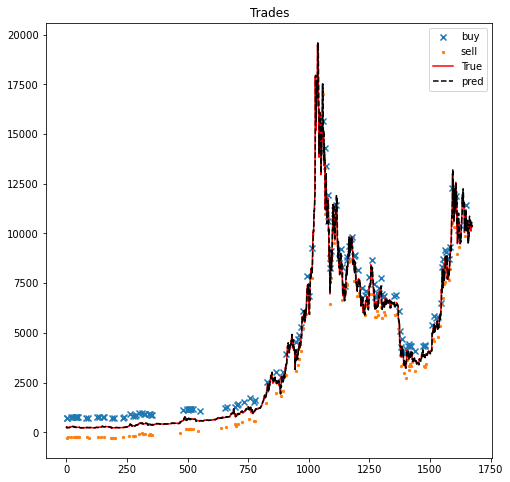

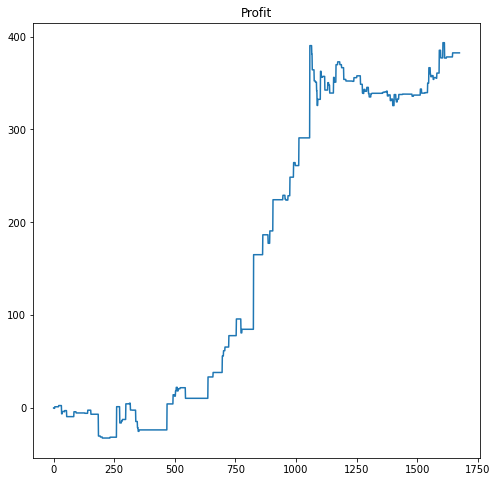

MSE: 87156.29
Sharpe: 0.19


In [11]:
# 第 4 部分
# 訓練模型
window = 150
preds = np.zeros(diff_len-window)
for i in range(diff_len-window-1):
    x_train = x_data[i:i+window, :]
    y_train = y_data[i:i+window]
    lr.fit(x_train, y_train)
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))

print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds))
simulate(data, preds)

Percentages MSE: 14.96


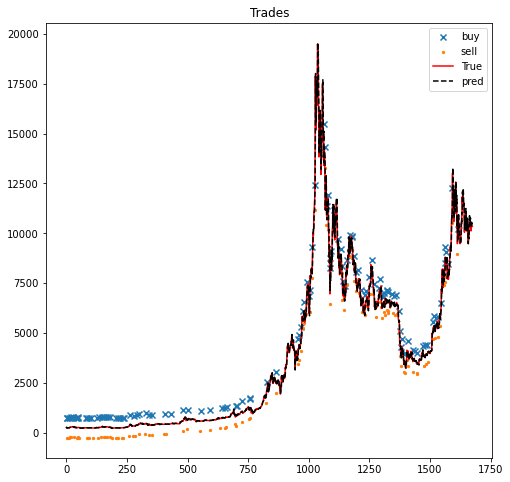

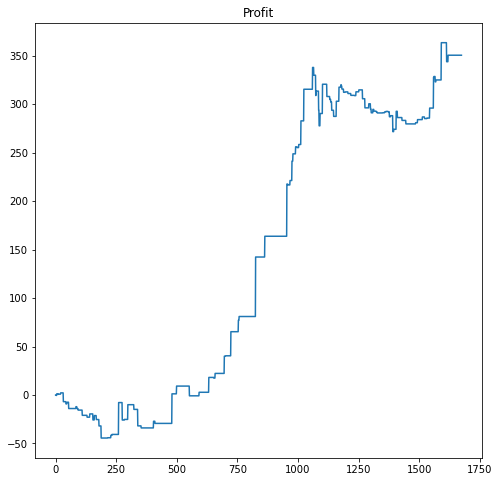

MSE: 86926.41
Sharpe: 0.22


In [12]:
# 第 5 部分
# 改進模型:移除線性迴歸基學習器
base_learners = [('SVR', SVR()), 
                 ('KNN', KNeighborsRegressor())]

lr = VotingRegressor(base_learners)

# 訓練模型
window = 150 
preds = np.zeros(diff_len-window) 
for i in range(diff_len-window-1): 
    x_train = x_data[i:i+window, :] 
    y_train = y_data[i:i+window] 
    lr.fit(x_train, y_train) 
    preds[i] = lr.predict(x_data[i+window+1, :].reshape(1, -1))

print('Percentages MSE: %.2f'%metrics.mean_squared_error(y_data[window:], preds)) 
simulate(data, preds)